# Parallel KMeans implementation
Based on J. Y. Q. H. Z. W. a. J. C. Bowen Wang, “Parallelizing K-means-based Clustering on Spark,” International Conference on Advanced Cloud and Big Data, 2016. 

## Parallel partition based algorithm outline
1. Initialize centroids by randomly selecting k points from the data set. Broadcast selected centroids to all nodes
1. While centrodis still changing:
    1. For each partition do locally:
        1. For each point in partition:
            1. Compute distance to all centroids
            1. Asign closest cluster
        1. For each cluster in partition:
            1. Compute local mean
    1. Compute mean for each cluster for each partition


## Adaptations made to sugested implementation of the algorithm:
1. The authors suggest using SparseVector, with chosen data sets it is better to use regular arrys
1. We use random sample for centroids initialization as described in *Scalable K-Means++* because quality of inital centrods has a major effect on quality
1. We use crisp clustring only i. e. each point can be a member of one cluster only

## Description of production cluster on Azure:
We are using Azure HDIsight in order to run a spark cluster. We are using a cluster with the following configuration:
* two master nodes Standard_D12_V2 4 CPU Cores 28GB RAM
* eight slave nodes Standard_D13_V2 8 CPU Cores 56GB RAM

In [1]:
import random 
import time
import math
from numpy import array
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.mllib.clustering import KMeans, KMeansModel
from itertools import groupby, compress

from typing import Tuple, Sequence

sc.setLogLevel('INFO')
# sc.stop()
# conf = SparkConf().set("spark.python.profile", "true")
# conf = SparkConf().set("spark.driver.memory", "29G")
# sc = SparkContext(conf=conf)

# For reproducability of results
RANDOM_SEED = 301191

%matplotlib inline

sc.getConf().getAll()

[('spark.driver.host', 'spark-standalone.internal.cloudapp.net'),
 ('spark.driver.port', '40487'),
 ('spark.driver.memory', '16G'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.name', 'PySparkShell'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.id', 'local-1599652624109')]

### Import test data and parse data set

In [2]:
data = sc.textFile("a3.txt")
parsed_data = data.map(lambda line: array([float(x) for x in line.strip().split()]))
parsed_data.cache()

parsed_data.take(5)

[array([53920., 42968.]),
 array([52019., 42206.]),
 array([52570., 42476.]),
 array([54220., 42081.]),
 array([54268., 43420.])]

In [2]:
def euclidean_dist(v1, v2):
    return np.linalg.norm(v1-v2)
    
def closest_centroid(point, centroids):
    # for dense data, we use euclidean distance
    centroid_dist_pairs = map(lambda centroid: (centroid, euclidean_dist(point, centroid)), centroids.value)
    return min(centroid_dist_pairs, key=lambda centroid_dist: centroid_dist[1])

def clac_mean_points_in_cluster_pandas(distances):
    # not in use. slower implementation of means calculation
    df = pd.DataFrame(distances, columns=['Point', 'Centroid', 'Distance'])
    df['Centroid'] = tuple(df['Centroid'])

    return df.groupby('Centroid')['Point'].apply(np.mean).items()

def clac_mean_points_in_cluster(distances):
    def keyfunc(item):
        return tuple(item[1])
    
    sorted_distances = sorted(distances, key=keyfunc)
    for k, g in groupby(sorted_distances, keyfunc):
        yield k, np.mean(array(list(g))[:,0], axis=0)

def calc_partition_centroid_means(partition, centroids):
    distances = map(lambda point: (point, 
                                   *closest_centroid(point, centroids)), 
                    partition)
    
    group = clac_mean_points_in_cluster(distances)
    return group

def closest_centroids_per_partition(data, centroids):
    """
    calculate local means for each centroid on each partition to avoid transfer of large volume of data
    
    @param data: rdd, the actual data set
    @param centroids:
    @return: rdd of tuples (original centroid, mean of points close to this centroid on each partition)
    """
    result = data.mapPartitions(lambda partition: calc_partition_centroid_means(partition, centroids))
    return result

def color_hash(point):
    hsh = int(point[0] ** 2 + point[1] ** 2)
    return '#' + str(hex(hsh % int('ffffff', 16)))[2:].zfill(6)

def calc_error(new_centroids_series: pd.DataFrame):
    old_and_new_centroids = array(list(new_centroids_series.items()))
    error = euclidean_dist(old_and_new_centroids[:,0], old_and_new_centroids[:,1])
    return error

def aggregate_means(closest_centroids):
    df = pd.DataFrame(closest_centroids, columns=['Centroid', 'Point']) 
    new_centroids_series = df.groupby('Centroid')['Point'].apply(np.mean)
    return new_centroids_series

def pkmeans(data, n, max_iterations=150, stop_distance=0.01):
    init_centroids = array(data.takeSample(False, n, seed=RANDOM_SEED))
    centroids = sc.broadcast(init_centroids)
    
    iteration = 1
    error = True
    while error > stop_distance and iteration <= max_iterations:
        loop_start = time.time()
        closest_centroids_rdd = closest_centroids_per_partition(data, centroids)
        closest_centroids = closest_centroids_rdd.collect()
        new_centroids_series = aggregate_means(closest_centroids)
        error = calc_error(new_centroids_series)
        print("Iteration #{0}\tDistance between old and new centroid: {1:.4f}\tIteration took: {2:.4f} sec".format(
                                                                iteration, error, time.time() - loop_start))
        centroids = sc.broadcast(new_centroids_series.to_list())
        iteration += 1
    
    return new_centroids_series.to_list()
    

In [3]:
final_centroids = pkmeans(parsed_data, 50)

Iteration #1	Distance between old and new centroid: 17177.0580	Iteration took: 1.7177 sec
Iteration #2	Distance between old and new centroid: 10533.1843	Iteration took: 1.4739 sec
Iteration #3	Distance between old and new centroid: 8960.0502	Iteration took: 1.4527 sec
Iteration #4	Distance between old and new centroid: 5625.2528	Iteration took: 1.4770 sec
Iteration #5	Distance between old and new centroid: 2716.5609	Iteration took: 1.4820 sec
Iteration #6	Distance between old and new centroid: 1167.5255	Iteration took: 1.4773 sec
Iteration #7	Distance between old and new centroid: 652.2470	Iteration took: 1.4191 sec
Iteration #8	Distance between old and new centroid: 426.8672	Iteration took: 1.6652 sec
Iteration #9	Distance between old and new centroid: 475.1348	Iteration took: 1.4710 sec
Iteration #10	Distance between old and new centroid: 436.4036	Iteration took: 1.4934 sec
Iteration #11	Distance between old and new centroid: 332.5501	Iteration took: 1.4316 sec
Iteration #12	Distance

### Run profiler to see what slows down

In [4]:
# %load_ext line_profiler

In [5]:
# def test_porfile():
#    pkmeans(parsed_data, 50)

In [6]:
# %lprun -f pkmeans test_porfile()

```
Timer unit: 1e-06 s

Total time: 27.4172 s
File: <ipython-input-150-1dd397ddc730>
Function: pkmeans at line 56

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    56                                           def pkmeans(data, n, max_iterations=150, stop_distance=0.01):
    57         1     101992.0 101992.0      0.4      init_centroids = array(data.takeSample(False, n, seed=RANDOM_SEED))
    58         1       2476.0   2476.0      0.0      centroids = sc.broadcast(init_centroids)
    59                                               
    60         1          1.0      1.0      0.0      iteration = 1
    61         1          0.0      0.0      0.0      error = True
    62        20         47.0      2.4      0.0      while error > stop_distance and iteration <= max_iterations:
    63        19         27.0      1.4      0.0          loop_start = time.time()
    64        19        435.0     22.9      0.0          closest_centroids_rdd = closest_centroids_per_partition(data, centroids)
    65        19   26590086.0 1399478.2     97.0          closest_centroids = closest_centroids_rdd.collect()
    66        19     648951.0  34155.3      2.4          new_centroids_series = aggregate_means(closest_centroids)
    67        19       3301.0    173.7      0.0          error = calc_error(new_centroids_series)
    68        19         34.0      1.8      0.0          print("Iteration #{0}\tDistance between old and new centroid: {1:.4f}\tIteration took: {2:.4f} sec".format(
    69        19       3429.0    180.5      0.0                                                                  iteration, error, time.time() - loop_start))
    70        19      66310.0   3490.0      0.2          centroids = sc.broadcast(new_centroids_series.to_list())
    71        19         32.0      1.7      0.0          iteration += 1
    72                                               
    73         1         33.0     33.0      0.0      return new_centroids_series.to_list()
 ```

__We can see that most time is spent on computation of closest_centroids_rdd.__ <br>
__Now, we will turn on the spark profiler to see what takes the most time__

In [7]:
# sc.show_profiles()

```
============================================================
Profile of RDD<id=7>
============================================================
         6135955 function calls (5760955 primitive calls) in 4.590 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   375000    1.419    0.000    2.767    0.000 linalg.py:2316(norm)
750055/375055    0.679    0.000    3.022    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   375000    0.619    0.000    3.914    0.000 <ipython-input-3-fc001fb89f2d>:1(euclidean_dist)
     7500    0.304    0.000    4.418    0.001 {built-in method builtins.min}
   375000    0.239    0.000    0.239    0.000 {method 'ravel' of 'numpy.ndarray' objects}
   375000    0.228    0.000    3.295    0.000 <__array_function__ internals>:2(norm)
   375000    0.215    0.000    0.700    0.000 <__array_function__ internals>:2(dot)
   382610    0.146    0.000    0.146    0.000 {built-in method numpy.array}
   375000    0.143    0.000    4.056    0.000 <ipython-input-3-fc001fb89f2d>:6(<lambda>)
   375000    0.101    0.000    0.219    0.000 _asarray.py:16(asarray)
   750110    0.099    0.000    0.099    0.000 {built-in method builtins.issubclass}
   375000    0.091    0.000    0.138    0.000 linalg.py:121(isComplexType)
   375000    0.058    0.000    0.058    0.000 <ipython-input-3-fc001fb89f2d>:7(<lambda>)
   375000    0.054    0.000    0.054    0.000 multiarray.py:707(dot)
   375000    0.051    0.000    0.051    0.000 linalg.py:2312(_norm_dispatcher)
        2    0.016    0.008    4.567    2.284 {built-in method builtins.sorted}
     7500    0.014    0.000    0.055    0.000 <ipython-input-2-1ef6232a3f15>:2(<lambda>)
     7502    0.014    0.000    0.039    0.000 serializers.py:684(loads)
    15000    0.013    0.000    0.013    0.000 <ipython-input-3-fc001fb89f2d>:17(keyfunc)
     7500    0.011    0.000    4.438    0.001 <ipython-input-3-fc001fb89f2d>:25(<lambda>)
     7500    0.010    0.000    0.010    0.000 <ipython-input-2-1ef6232a3f15>:2(<listcomp>)
     7500    0.009    0.000    4.427    0.001 <ipython-input-3-fc001fb89f2d>:4(closest_centroid)
     7502    0.009    0.000    0.018    0.000 serializers.py:721(read_int)
     7502    0.007    0.000    0.045    0.000 serializers.py:693(load_stream)
    15002    0.006    0.000    0.006    0.000 {method 'read' of '_io.BufferedReader' objects}
     7500    0.006    0.000    0.061    0.000 util.py:97(wrapper)
       55    0.006    0.000    0.006    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     7500    0.005    0.000    0.005    0.000 {method 'decode' of 'bytes' objects}
     7502    0.005    0.000    0.005    0.000 {built-in method _struct.unpack}
     7500    0.004    0.000    0.004    0.000 {method 'split' of 'str' objects}
       57    0.004    0.000    4.587    0.080 <ipython-input-3-fc001fb89f2d>:16(clac_mean_points_in_cluster)
     7500    0.002    0.000    0.002    0.000 {method 'strip' of 'str' objects}
        2    0.001    0.001    4.589    2.295 serializers.py:396(dump_stream)
       10    0.001    0.000    0.001    0.000 {built-in method _pickle.dumps}
       55    0.001    0.000    0.006    0.000 _methods.py:134(_mean)
        2    0.000    0.000    0.000    0.000 {built-in method _pickle.load}
       55    0.000    0.000    0.006    0.000 fromnumeric.py:3231(mean)
       55    0.000    0.000    0.000    0.000 _methods.py:50(_count_reduce_items)
        2    0.000    0.000    0.000    0.000 {built-in method io.open}
       55    0.000    0.000    0.007    0.000 <__array_function__ internals>:2(mean)
      110    0.000    0.000    0.000    0.000 {built-in method builtins.isinstance}
        2    0.000    0.000    0.001    0.000 broadcast.py:123(load_from_path)
        2    0.000    0.000    4.590    2.295 worker.py:370(process)
       55    0.000    0.000    0.000    0.000 _asarray.py:88(asanyarray)
       10    0.000    0.000    0.000    0.000 serializers.py:728(write_int)
       10    0.000    0.000    0.001    0.000 serializers.py:582(dumps)
        2    0.000    0.000    0.001    0.000 broadcast.py:135(value)
        2    0.000    0.000    0.000    0.000 broadcast.py:127(load)
       20    0.000    0.000    0.000    0.000 {method 'write' of '_io.BufferedWriter' objects}
       55    0.000    0.000    0.000    0.000 fromnumeric.py:3227(_mean_dispatcher)
        2    0.000    0.000    0.001    0.000 <ipython-input-3-fc001fb89f2d>:40(<lambda>)
       10    0.000    0.000    0.000    0.000 {built-in method _struct.pack}
        2    0.000    0.000    0.001    0.000 rdd.py:2498(pipeline_func)
        2    0.000    0.000    0.000    0.000 rdd.py:323(func)
        2    0.000    0.000    0.000    0.000 {built-in method builtins.hasattr}
        2    0.000    0.000    0.001    0.000 rdd.py:351(func)
       20    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        2    0.000    0.000    0.000    0.000 <ipython-input-3-fc001fb89f2d>:24(calc_partition_centroid_means)
        2    0.000    0.000    0.000    0.000 util.py:92(fail_on_stopiteration)
        2    0.000    0.000    0.000    0.000 {built-in method builtins.iter}
        2    0.000    0.000    0.000    0.000 {built-in method gc.enable}
        2    0.000    0.000    0.000    0.000 {built-in method gc.disable}
        2    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

```

__We can see that most of the time is spent on calculation in numpy, python is a slower language__

## Claster validitiy
***
We are looking for a “good” structure of found clusters. We will use two meassures compactness and separation which are the most popular ones.

The Compactness measures how closely data points are grouped in a cluster. Grouped points in the cluster are supposed to be related to each other, by sharing a common feature which reﬂects a meaningful pattern in practice. Compactness is normally based on distances between in cluster points. The very popular way of calculating the compactness is through variance, i.e., average distance to the mean, to estimate how objects are bonded together with its mean as its center. A small variance indicates a high compactness.

The Separation measures how different the found clustersare from each other. A distinct cluster that is far from the others corresponds to a unique pattern. Similar to the compactness, the distances between objects are widely used to measure separation, e.g., pairwise distances between cluster centers, or pairwise minimum distances between objects in different clusters. Separation is an inter-cluster criterionin the sense of relation between clusters. 

$D$ - the whole data set<br>
$g$ - center of whole data set<br>
$P$ - number of dimentions<br>
$C_i$ - i-th cluster<br>
$n_i$ - number of datat points in $C_i$<br>
$c_i$ - center of cluster $C_i$<br>


### RMSSTD cacluation


RMSSTD is a square root of the pooled sample variance of all the attributes, which measures only the compactness of found clusters. Since the objective of cluster analysis is to form homogeneus groups the RMSSTD of a cluster should be as small as possible.

$RMSSTD= \sqrt{\large{\frac{\sum_{i}\sum_{x \in C_i}\lVert x - c_i \rVert ^ 2}
{P\sum_{i}(n_i - 1)}}}$


### RS calculation


RS is the complement of the ratio of sum of squared distances between objects in different clusters to the total sum of squares. It is an intuitive and simple formulation of measuring the differences between clusters. THe values of RS are between 0 and 1. In case that the values of RS is zero indicates that no difference exist among groups. On the other hand, when RS equals 1 there is an indication of significant difference among groups.

$RS = \large\frac
{\sum_{x \in D} \lVert x-g \rVert ^2 - \sum_{i}\sum_{x \in C_i} \lVert x - c_i \rVert ^2 }
{\sum_{x \in D} \lVert x-g \rVert ^2}$



In [3]:
def calc_point_centroid_pairs(data, centroids) -> pyspark.rdd.RDD:
    return data.map(lambda point: (tuple(closest_centroid(point, centroids)[0]), point))

def sum_of_squares_(centroid_points):
    s = 0
    points_ct = 0
    
    dim = len(centroid_points[0])    # get dimention of the point
    
    for centroid, points in centroid_points:
        centroid_arr = array(centroid)
        for point in points:
            s += euclidean_dist(point, centroid_arr)
            points_ct += 1    # count actual number of points in all the clusters
        points_ct -= 1        # required by the formula, reduce count by one
        
    return math.sqrt(s / (dim * points_ct))

def sum_of_squares_rmsstd(centroid_points):
    s = 0
    points_ct = 0
    
    centroid, points = centroid_points
    centroid_arr = array(centroid)
    
    for point in points:
        s += euclidean_dist(point, centroid_arr)
        points_ct += 1
    
    return s, points_ct - 1  

def sum_of_squares_rs(centroid_points):
    s = 0
    
    centroid, points = centroid_points
    centroid_arr = array(centroid)
    
    for point in points:
        s += euclidean_dist(point, centroid_arr)
    
    return s

def rmsstd(data: pyspark.rdd.RDD, centroids):
    dim = len(data.first())
    
    point_centroid_pairs = calc_point_centroid_pairs(data, centroids)
    s, n = point_centroid_pairs.groupByKey().map(sum_of_squares_rmsstd).reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
    return math.sqrt(s / (dim * n))

def rs(data: pyspark.rdd.RDD, centroids):
    g = data.mean()    # calc center of data
    sum_of_squares_total = data.map(lambda point: euclidean_dist(point, g)).sum()
    
    point_centroid_pairs = calc_point_centroid_pairs(data, centroids)
    sum_of_squres_clusters = point_centroid_pairs.groupByKey().map(sum_of_squares_rs).sum()
    
    return (sum_of_squares_total - sum_of_squres_clusters) / sum_of_squares_total
    


### Now we will run mllib kmeans algorithm and compare it to our result
* The first test of the algorithm is a syntetic data test
* Yellow sqares represent the data.
* Read dots are centers of clusters compueted by our implementation
* Black dots are the centerts of cluster computed by spark mllib algorithm

In [9]:
mllib_clusters = KMeans.train(parsed_data, 50, maxIterations=150, initializationMode="random")

In [10]:
rmsstd_custom = rmsstd(parsed_data, final_centroids)
rmsstd_mllib = rmsstd(parsed_data, mllib_clusters.centers)
rs_custom = rs(parsed_data, final_centroids)
rs_mmlib = rs(parsed_data,  mllib_clusters.centers)

print(f"our algorithm\trmsstd: {rmsstd_custom}\trs: {rs_custom}")
print(f"mllib algorithm\trmsstd: {rmsstd_mllib}\trs: {rs_mmlib}")

our algorithm	rmsstd: 33.05817971660287	rs: 0.908514342499134
mllib algorithm	rmsstd: 31.673865937096473	rs: 0.9160158580631229


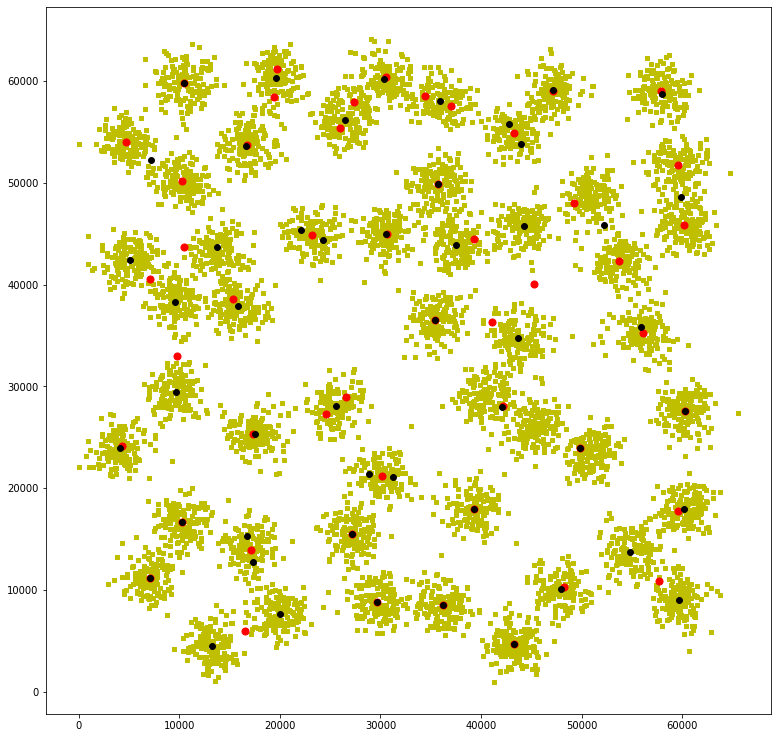

In [11]:
xdata, ydata = np.hsplit(array(parsed_data.collect()), 2)

x, y = np.hsplit(array(final_centroids), 2) 
fig = plt.figure(figsize=(13, 13))
ax1 = fig.add_subplot(111)


x1, y1 = zip(*mllib_clusters.centers)

ax1.scatter(xdata, ydata, s=10, color='y', marker="s")
ax1.scatter(x, y, s=50, color='r', marker="o")
ax1.scatter(x1, y1, s=35, color='k', marker="o")

***
## PKmeans evaluation on large sets
***

### KDD Cup 1999 data set
Load and clean the data set. <br>
Then, use built in spark stats to analize the data set.

In [4]:
kdd_data = sc.textFile("kddcup1999")
kdd_parsed_data = kdd_data.map(lambda line: line.strip().split(','))
kdd_parsed_data.cache()

PythonRDD[2] at RDD at PythonRDD.scala:53

In [4]:
kdd_fields = [  "duration",
                "protocol_type",
                "service",
                "flag",
                "src_bytes",
                "dst_bytes",
                "land",
                "wrong_fragment",
                "urgent",
                "hot",
                "num_failed_logins",
                "logged_in",
                "num_compromised",
                "root_shell",
                "su_attempted",
                "num_root",
                "num_file_creations",
                "num_shells",
                "num_access_files",
                "num_outbound_cmds",
                "is_host_login",
                "is_guest_login",
                "count",
                "srv_count",
                "serror_rate",
                "srv_serror_rate",
                "rerror_rate",
                "srv_rerror_rate",
                "same_srv_rate",
                "diff_srv_rate",
                "srv_diff_host_rate",
                "dst_host_count",
                "dst_host_srv_count",
                "dst_host_same_srv_rate",
                "dst_host_diff_srv_rate",
                "dst_host_same_src_port_rate",
                "dst_host_srv_diff_host_rate",
                "dst_host_serror_rate",
                "dst_host_srv_serror_rate",
                "dst_host_rerror_rate",
                "dst_host_srv_rerror_rate"
]

In [42]:
stats = kdd_parsed_data.toDF(schema=kdd_fields).describe()

In [61]:
stats.toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
duration,4898431,48.34243046395876,723.3298112546689,0,9997
protocol_type,4898431,None,None,icmp,udp
service,4898431,None,None,IRC,whois
flag,4898431,None,None,OTH,SH
src_bytes,4898431,1834.6211752293746,941431.0744911329,0,999
dst_bytes,4898431,1093.6228137132073,645012.3337425241,0,9999
land,4898431,5.716116037972159E-6,0.002390833438554667,0,1
wrong_fragment,4898431,6.487791703098401E-4,0.04285433675493736,0,3
urgent,4898431,7.961733052889793E-6,0.007215083685169118,0,5


We will use only the numeric fields for clustering.

In [4]:
numeric_fields = [
    "duration",
    "src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file_creations",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login",
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate",
    "rerror_rate",
    "srv_rerror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate",
]

In [4]:
fields_filter = [1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0]
len(fields_filter)

42

In [4]:
def parse_kdd_line_filter_fields(line):
    split_line = line.strip().split(',')
    return array(list(map(float, compress(split_line, fields_filter))))
    
    
kdd_data = sc.textFile("kddcup1999")
kdd_parsed_data_clean = kdd_data.map(parse_kdd_line_filter_fields)
kdd_parsed_data_clean.cache()



PythonRDD[2] at RDD at PythonRDD.scala:53

In [5]:
kdd_centroids = pkmeans(kdd_parsed_data_clean, 150)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 5 in stage 0.0 failed 1 times, most recent failure: Lost task 5.0 in stage 0.0 (TID 5, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 400, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-4-2fe4a69059e5>", line 3, in parse_kdd_line_filter_fields
NameError: name 'fields_filter' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:592)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:575)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:221)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsBytes(MemoryStore.scala:349)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1182)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1091)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:882)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:357)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:308)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1891)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1879)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1878)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2112)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2061)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2050)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:738)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:990)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:385)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:989)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 400, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-4-2fe4a69059e5>", line 3, in parse_kdd_line_filter_fields
NameError: name 'fields_filter' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:592)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:575)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:221)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsBytes(MemoryStore.scala:349)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1182)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1091)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:882)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:357)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:308)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [9]:
t = time.time()
mllib_clusters = KMeans.train(kdd_parsed_data_clean, 30, maxIterations=150, initializationMode="random")
mllib_clusters.centers
print("Took", time.time() - t, "seconds")

Took 63.33879280090332 seconds


In [10]:
rmstd_kdd_mllib = rmsstd(kdd_parsed_data_clean, mllib_clusters.centers)
rmstd_kdd_mllib

In [11]:
rmstd_kdd_mllib

5.433773226847